In [2]:
import tensorflow as tf

In [3]:
import deepchem as dc
import rdkit as rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import pandas as pd

In [4]:
import numpy as np

In [5]:
print('tf version:', tf.__version__, '\nGPU avilable?:', tf.config.list_physical_devices('GPU'))
print('rdkit version: ', rdkit.__version__)
print('DeepChem version', dc.__version__)

tf version: 2.3.0 
GPU avilable?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
rdkit version:  2020.09.1
DeepChem version 2.4.0-rc1.dev


In [6]:
from feat.simple_mol_graph_conv_featurizer import SimpleMolGraphConvFeaturizer

In [7]:
data = pd.read_csv('./data/QM9_HAC_5_9_.csv')

In [8]:
reduced_data = list(data['SMILES'][:3])

In [9]:
reduced_data[1]

'N1C=CC=C1'

In [10]:
mols = [Chem.MolFromSmiles(x) for x in reduced_data]

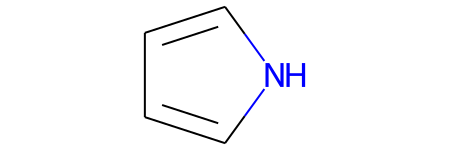

In [11]:
mol = mols[1]
mol

In [18]:
mol.GetNumBonds()

5

In [39]:
from deepchem.feat.graph_data import GraphData
from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol

bond_labels = [
    Chem.rdchem.BondType.SINGLE
    ,Chem.rdchem.BondType.DOUBLE
    ,Chem.rdchem.BondType.TRIPLE
    ,Chem.rdchem.BondType.AROMATIC]
bond_encoder = {l: i for i, l in enumerate(bond_labels)}
bond_decoder = {i: l for i, l in enumerate(bond_labels)}

atom_labels = [0, 6, 8, 7, 16, 15, 9, 17] #Unknown, C, O, N, S, P, F, Cl
atom_encoder = {l: i for i, l in enumerate(atom_labels)}
atom_decoder = {i: l for i, l in enumerate(atom_labels)}

def _bond_features(mol):
    bonds = []
    for b in mol.GetBonds():
        # 2x in order to match 2nd dimension of bond_indices in GraphData object
        try:
            bonds += 2*[bond_encoder[b.GetBondType()]]
        except Exception as e:
            raise ValueError('Unsupported bond type detected', e.args[0])
    # depth is equal to encoding lenght == number of bond types
    a = tf.one_hot(bonds, depth=4, dtype=tf.float32)
    #convert to np.ndarray to comply with GraphData object structure
    proto_tensor = tf.make_tensor_proto(a)
    return tf.make_ndarray(proto_tensor)

def _atom_features(mol):
    try:
        atoms = [atom_encoder[atom.GetAtomicNum()] for atom in mol.GetAtoms()]
    except Exception as e:
        raise ValueError('Unsupported atom type detected', e.args[0])  
    # depth is equal to encoding lenght == number of atom types
    a = tf.one_hot(atoms, depth=8, dtype=tf.float32)
    #convert to np.ndarray to comply with GraphData object structure
    proto_tensor = tf.make_tensor_proto(a)
    return tf.make_ndarray(proto_tensor)

def _bond_indices(mol):
    src, dest = [], []
    for bond in mol.GetBonds():
        # add edge list considering a directed graph
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        src += [start,end]
        dest += [end,start]
    return np.asarray([src, dest], dtype=np.int)

def SimpleFeaturizer(mol):
    return GraphData(node_features=_atom_features(mol), edge_index=_bond_indices(mol), edge_features=_bond_features(mol))

In [40]:
g = SimpleFeaturizer(mol)

In [41]:
g.node_features

array([[0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [42]:
g.edge_features

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [43]:
g.edge_index

array([[0, 1, 1, 2, 2, 3, 3, 4, 4, 0],
       [1, 0, 2, 1, 3, 2, 4, 3, 0, 4]])

In [15]:
def revert(graph_data : GraphData) -> RDKitMol:
    node_features = graph_data.node_features
    bond_features = graph_data.edge_features
    bond_indices = graph_data.edge_index
    
    mol = Chem.RWMol()
    for feature in node_features:
        code = np.argmax(feature, axis=0)
        mol.AddAtom(Chem.Atom(atom_decoder[code]))
    
    for i, feature in enumerate()
    return mol

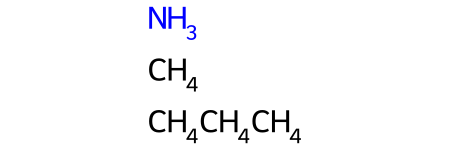

In [16]:
revert(g)

In [ ]:
    def matrices2mol(self, node_labels, edge_labels, strict=False):
        mol = Chem.RWMol()

        for node_label in node_labels:
            mol.AddAtom(Chem.Atom(self.atom_decoder_m[node_label]))

        for start, end in zip(*np.nonzero(edge_labels)):
            if start > end:
                mol.AddBond(int(start), int(end), self.bond_decoder_m[edge_labels[start, end]])

        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None

        return mol